In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Paths & URLs

import os

# Enable CUDA stacktrace reporting for debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"
os.environ['PYTORCH_NO_CUDA_MEMORY_CACHING'] = "1"
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Directorio base
#PATH_BASE = '/content/drive/MyDrive/proximity'
#PATH_BASE = 'C:\\Users\\User\\Documents\\Proyecto Proximity'
PATH_BASE = 'E:\\files\\Documents\\Proyecto Proximity'

# Data release actual
DR70_PATH = os.path.join(PATH_BASE, 'DR70')
DR70_CT_PATH = os.path.join(DR70_PATH, 'datalake_sorted')
DR70_LABELS_PATH = os.path.join(DR70_PATH, 'labels.csv')

# Data release 176
DR176_PATH = os.path.join(PATH_BASE, 'DR176')
DR176_CT_PATH = os.path.join(DR176_PATH, 'DR176_studies')
DR176_LABELS_PATH = os.path.join(PATH_BASE, 'reports_with_label.csv')


# Data release 217
DR217_PATH = os.path.join(PATH_BASE, 'DR217')
DR217_CT_PATH = os.path.join(DR217_PATH, 'DR217_studies')
DR217_LABELS_PATH = os.path.join(DR217_PATH, 'DR217_labels.csv')
# Used for normalization of the intensity values for each CT
DR217_CT_HISTOGRAM_LANDMARKS_PATH = os.path.join(DR217_PATH, 'DR217_histogram_landmarks.npy')
# Embeddings ResNet18 DR217
DR217_RESNET_EMBEDDINGS_PATH = os.path.join(DR217_PATH, 'DR217_resnet18_embeddings')

# Synth dataset v1
SYNTH_DATASET_V1_PATH = os.path.join(PATH_BASE, 'Synth dataset v1', 'v1', 'npz')

# CTs in Nibabel format
CT_NIBABEL_PATH = os.path.join(PATH_BASE, 'DR70', 'CTs')

# Embeddings visuales de CTs
#CT_EMBEDDINGS_PATH = DATA_RELEASE_PATH + '/visual_embeddings'


# Etiquetas de los CTs del data release actual
#CT_LABELS_CSV_PATH = DATA_RELEASE_PATH + '/labels.csv'

# Data release (CTs + etiquetas) organizados en un DataFrame
#CT_DATASET_DF_HDF_PATH = os.path.join(PATH_BASE, 'dataset_df.h5')
#CT_DATASET_DF_PICKLE_PATH = os.path.join(PATH_BASE, 'dataset_df.pickle')

# URLs de modelos visuales
#RESNET18_URL = 'microsoft/resnet-18'

# Path que contiene los resnet50 embeddings de CTs del data release actual
#CT_RESNET18_EMBEDDINGS_PATH = os.path.join(DR70_PATH, 'visual_embeddings', 'resnet18')
#CT_RESNET18_EMBEDDINGS_PATH = os.path.join(DR70_PATH, 'visual_embeddings', 'resnet18', 'reshaped_averaged')

# Path de modelos entrenados en base a tripletas
TRIPLET_MODELS_PATH = os.path.join(PATH_BASE, 'retrieval_models', 'triplets')
TRIPLET_CHECKPOINTS_PATH = os.path.join(PATH_BASE, 'retrieval_models', 'triplets', 'checkpoints')

# Path de modelos entrenados con clasificacion
CLASSIFICATION_MODELS_PATH = os.path.join(PATH_BASE, 'retrieval_models', 'clasification')
CLASSIFICATION_CHECKPOINTS_PATH = os.path.join(CLASSIFICATION_MODELS_PATH, 'checkpoints')

In [8]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

#proximity_vector_labels = [[0,0,0], [1,0,0], [0,1,0], [0,0,1], [1,0,1], [1,1,0], [0,1,1], [1,1,1]]
proximity_vector_labels = [[0], [1]]
#proximity_classes = ['(s/a)', 'c', 'n', 'q', 'c+n', 'c+q', 'n+q', 'c+n+q']
proximity_classes = ['No sphere', 'Sphere']
#proximity_colors = ['#000000', '#ff0000', '#00ff00', '#0000ff',
#              '#ff00ff', '#ffff00', '#00ffff', '#ffffff']
proximity_colors = ['#000000', '#0000ff']

mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    ax = plt.gca()
    ax.set_facecolor('#D1D1D1')
    xlim = (embeddings[:, 0].min(), embeddings[:, 0].max())
    xradius = (xlim[1] - xlim[0]) / 2
    xcenter = xlim[0] + xradius
    xlim = (xcenter - 1.1*xradius, xcenter + 1.1*xradius)
    ylim = (embeddings[:, 1].min(), embeddings[:, 1].max())
    yradius = (ylim[1] - ylim[0]) / 2
    ycenter = ylim[0] + yradius
    ylim = (ycenter - 1.1*yradius, ycenter + 1.1*yradius)
    for i in range(len(proximity_vector_labels)):
        #inds = np.where(targets==i)[0]
        new_mask = [(t == proximity_vector_labels[i]).all() for t in targets]
        #plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
        #embeddings_x = (embeddings[new_mask,0] - embeddings[new_mask,0].min()) / (embeddings[new_mask,0].max() - embeddings[new_mask,0].min())
        #embeddings_y = (embeddings[new_mask,1] - embeddings[new_mask,1].min()) / (embeddings[new_mask,1].max() - embeddings[new_mask,1].min())
        #plt.scatter(embeddings_x, embeddings_y, alpha=0.5, edgecolors=proximity_colors[i], color=proximity_colors[i])
        plt.scatter(embeddings[new_mask,0], embeddings[new_mask,1], alpha=0.6, edgecolors=proximity_colors[i], color=proximity_colors[i])
        
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(proximity_classes)
    plt.show()

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros((len(dataloader.dataset), 1))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model(images).data.cpu().numpy()
            labels[k:k+len(images)] = target
            k += len(images)
            #break
    print(embeddings)
    print(labels)
    return embeddings, labels

# Experimento 1: entrenamiento por tripletas sobre dataset de volúmenes de una clase

Objetivo: detección de esferas en el volumen de entrada

In [ ]:
from datasets import SynthVolumeDataset, BalancedBatchSampler
import torch
from torchvision.transforms import v2
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.utils.data import default_collate

from trainer import fit
import numpy as np

import random
from pathlib import Path

cuda = torch.cuda.is_available()

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

# Set up data loaders
training_split_ratio = 0.8

volumes_path_list = sorted(Path(SYNTH_DATASET_V1_PATH).glob('*.npz'))

num_subjects = len(volumes_path_list)
num_training_subjects = int(training_split_ratio * num_subjects)
num_validation_subjects = num_subjects - num_training_subjects

num_split_data = (num_training_subjects, num_validation_subjects)

training_data_paths, validation_data_paths = torch.utils.data.random_split(volumes_path_list, num_split_data)

transforms_composite = v2.Compose([
    v2.Grayscale(num_output_channels=1),
    v2.Resize((100, 100)),
    v2.ToDtype(torch.float32, scale=True), # with scale=True, scales pixel values from [0, 255] to [0.0, 1.0]
    v2.Normalize(mean=[0.449], std=[0.226])
])

#triplet_training_set = SynthVolumeDataset(training_data_paths, transforms=transforms_composite, train=True)
#triplet_validation_set = SynthVolumeDataset(validation_data_paths, transforms=transforms_composite, train=False)
triplet_training_set = SynthVolumeDataset(training_data_paths, preprocessed=True, train=True)
triplet_validation_set = SynthVolumeDataset(validation_data_paths, preprocessed=True, train=False)

print('Training set size:', len(triplet_training_set))
print('Validation set size:', len(triplet_validation_set))

def collate(batch):
    batch = list(filter(lambda x:x is not None, batch))
    return default_collate(batch)


# balanced batch sampler: batch size is n_classes*n_samples. Each batch contains n_samples samples for n_classes randomly selected classes.
train_batch_sampler = BalancedBatchSampler(triplet_training_set.labels_as_classes, n_classes=2, n_samples=5)
test_batch_sampler = BalancedBatchSampler(triplet_validation_set.labels_as_classes, n_classes=2, n_samples=5)


# Set up data loaders
n_classes = 2
batch_size = 8
kwargs = {'num_workers': 0, 'pin_memory': True} if cuda else {}
#triplet_train_loader = torch.utils.data.DataLoader(triplet_training_set, batch_size=batch_size, shuffle=True, collate_fn=collate, **kwargs)
#triplet_test_loader = torch.utils.data.DataLoader(triplet_validation_set, batch_size=batch_size, shuffle=False, collate_fn=collate, **kwargs)
triplet_train_loader = torch.utils.data.DataLoader(triplet_training_set, batch_sampler=train_batch_sampler, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_validation_set, batch_sampler=test_batch_sampler, **kwargs)



# Set up the network and training parameters
from networks import SynthDataEmbeddingModel, ClassificationNet
from losses import OnlineTripletLoss
from utils import HardestNegativeTripletSelector
from metrics import AverageNonzeroTripletsMetric

margin = 0.2
embedding_net = SynthDataEmbeddingModel(embedding_size=2)
#model = ClassificationNet(embedding_net, embedding_size=2, n_classes=n_classes)
model = embedding_net
if cuda:
    model.cuda()
    
loss_fn = OnlineTripletLoss(margin, HardestNegativeTripletSelector(margin))
lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 50, gamma=0.1, last_epoch=-1)
n_epochs = 50
log_interval = 1

In [ ]:
print(model)

SynthDataEmbeddingModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [ ]:
fit(
    triplet_train_loader, 
    triplet_test_loader, 
    model, 
    loss_fn, 
    optimizer, 
    scheduler, 
    n_epochs, 
    cuda, 
    log_interval,
    TRIPLET_CHECKPOINTS_PATH,
    metrics=[AverageNonzeroTripletsMetric()]
)

  0%|          | 0/50 [00:00<?, ?it/s]


### EPOCH 1 START ###

### TRAINING LOSS ###
OnlineTripletLoss.forward()
embeddings:
tensor([[ 0.0257, -0.0045],
        [ 0.0065, -0.0111],
        [ 0.0146, -0.0116],
        [ 0.0116, -0.0161],
        [ 0.0164, -0.0098],
        [ 0.0187, -0.0124],
        [ 0.0117, -0.0051],
        [ 0.0148, -0.0120],
        [ 0.0117, -0.0144],
        [ 0.0150, -0.0001]], device='cuda:0', grad_fn=<MmBackward0>)
target:
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1]], device='cuda:0')
FunctionNegativeTripletSelector.get_triplets()
distance_matrix:
tensor([[1.0000, 0.6452, 0.8801, 0.7164, 0.9349, 0.9162, 0.9725, 0.8735, 0.7571,
         0.9861],
        [0.6452, 1.0000, 0.9306, 0.9953, 0.8743, 0.8972, 0.8055, 0.9355, 0.9876,
         0.5092],
        [0.8801, 0.9306, 1.0000, 0.9618, 0.9913, 0.9966, 0.9665, 0.9999, 0.9765,
         0.7889],
        [0.7164, 0.9953, 0.9618, 1.0000, 0.9174, 0.9359, 0.8593, 0.9654, 0.9

KeyboardInterrupt: 

[[-0.03476697 -0.33190811]
 [-0.02961301 -0.18899968]
 [-0.02532617 -0.31101149]
 [-0.0188499  -0.15995772]
 [-0.03042392 -0.35095602]
 [ 0.19900659  0.0678479 ]
 [ 0.2723583   0.08276503]
 [ 0.20920002  0.05521594]
 [ 0.20629662  0.07283533]
 [ 0.18814692  0.04425617]
 [ 0.23756543  0.06777555]
 [ 0.23200069  0.06260462]
 [ 0.2706272   0.08653326]
 [ 0.26462567  0.079833  ]
 [ 0.15579987  0.0401656 ]
 [-0.01458742 -0.1254968 ]
 [-0.02599984 -0.17721015]
 [-0.02712069 -0.17044525]
 [-0.0208034  -0.1598935 ]
 [-0.01694075 -0.14471348]
 [ 0.18230866  0.04705404]
 [ 0.51327914  0.14985989]
 [ 0.25584278  0.07770248]
 [ 0.20902537  0.06215829]
 [ 0.12839365  0.02976825]
 [-0.02299767 -0.18170768]
 [-0.02474617 -0.2845391 ]
 [-0.02891408 -0.28401837]
 [-0.02767047 -0.32418188]
 [-0.02710713 -0.28567377]
 [-0.0292524  -0.26101676]
 [-0.01957107 -0.18784943]
 [-0.03255775 -0.26747128]
 [-0.04041354 -0.34239894]
 [-0.01266485 -0.1346193 ]
 [ 0.30426392  0.0807448 ]
 [ 0.18269345  0.0557019 ]
 

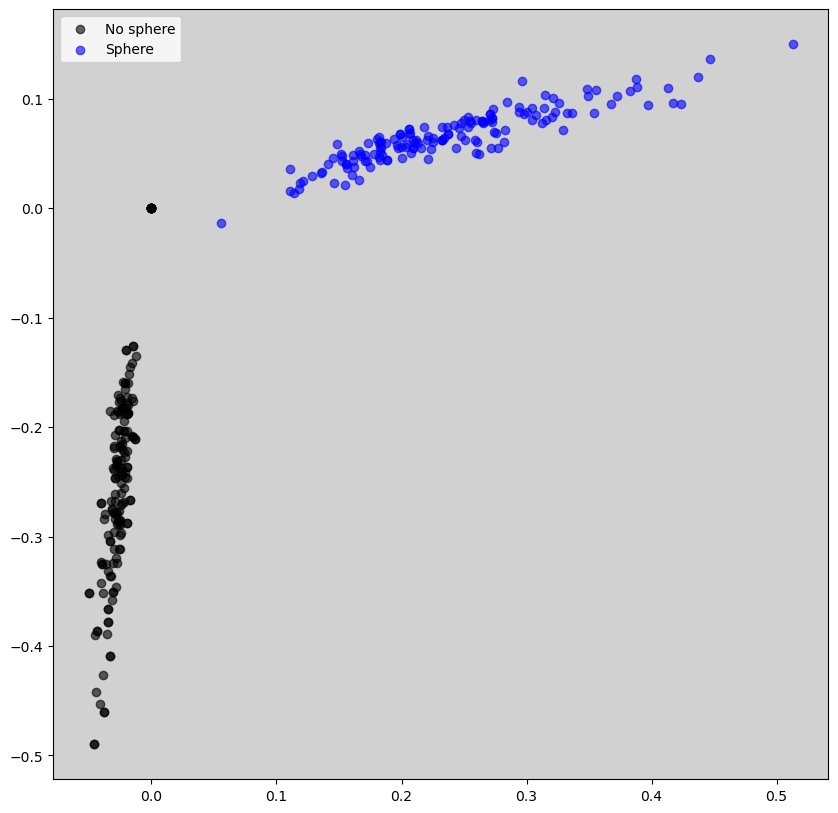

[[-0.02466194 -0.26023293]
 [-0.02144964 -0.22058445]
 [-0.03377625 -0.40521869]
 [-0.0236824  -0.17981452]
 [-0.01588759 -0.22270906]
 [ 0.21001348  0.05582015]
 [ 0.11226052  0.03195442]
 [ 0.37664509  0.10273558]
 [ 0.29265812  0.08240873]
 [ 0.16242443  0.05002932]
 [-0.02570425 -0.17609575]
 [-0.02075533 -0.1610207 ]
 [-0.02202727 -0.20946993]
 [-0.03239324 -0.29285455]
 [-0.02910346 -0.26032016]
 [ 0.2772606   0.07816623]
 [ 0.21798587  0.07893261]
 [ 0.2939114   0.08616668]
 [ 0.27465177  0.08789405]
 [ 0.23428774  0.07591835]
 [-0.02643277 -0.19018592]
 [-0.01985732 -0.1696381 ]
 [-0.01837263 -0.14052224]
 [-0.0286408  -0.20638442]
 [-0.03047355 -0.23950027]
 [ 0.26212737  0.08117023]
 [ 0.24990964  0.08295404]
 [ 0.32002267  0.090098  ]
 [ 0.12306896  0.02253237]
 [ 0.30661693  0.0860012 ]
 [-0.02546913 -0.22367045]
 [-0.02740937 -0.23677704]
 [-0.03229997 -0.24959274]
 [-0.03777773 -0.45672783]
 [-0.02158087 -0.23275228]
 [ 0.18788528  0.04792101]
 [ 0.14847818  0.05139871]
 

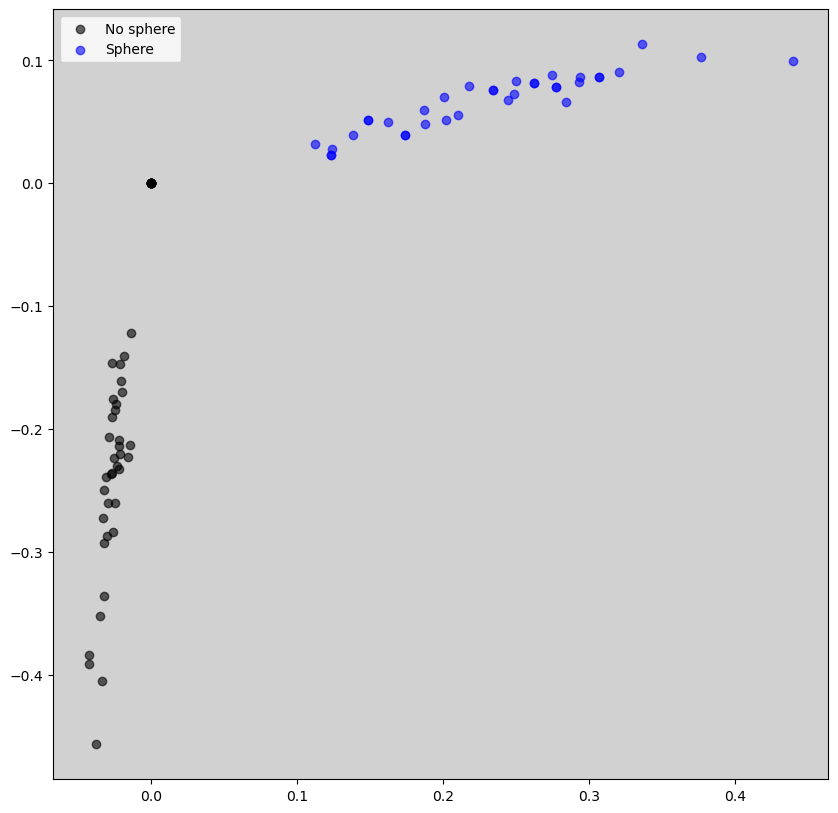

In [ ]:
train_embeddings_tl, train_labels_tl = extract_embeddings(triplet_train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(triplet_test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)

In [5]:
from torchviz import make_dot


batch_x, batch_y = next(iter(triplet_train_loader))
output = model(batch_x.cuda())

make_dot(output, params=dict(model.named_parameters()), show_attrs=True, show_saved=True).render("nn", format="jpg")

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\torchvision\io\video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH